# ALMA Data Example

Trey V. Wenger (c) December 2024

Here we test `bayes_cn_hfs` on some real ALMA data and demonstrate a general procedure for determining the carbon isotopic ratio from observations of CN and 13CN.

In [1]:
# General imports   
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+3.g8d34583.dirty


## Load the data

12CN 1021
13CN 1021


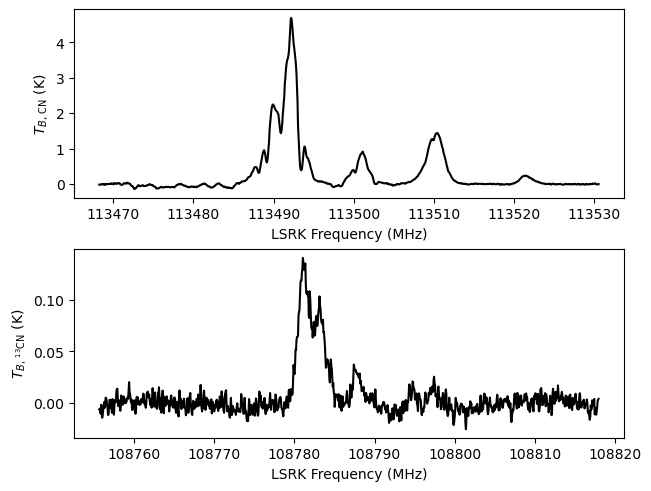

In [2]:
from bayes_spec import SpecData

data_12CN = np.genfromtxt("data_CN.tsv")
data_13CN = np.genfromtxt("data_13CN.tsv")

# estimate noise
noise_12CN = 1.4826 * np.median(np.abs(data_12CN[:, 0] - np.median(data_12CN[:, 0])))
noise_13CN = 1.4826 * np.median(np.abs(data_13CN[:, 0] - np.median(data_13CN[:, 0])))

obs_12CN = SpecData(
    1000.0 * data_12CN[:, 0],
    data_12CN[:, 1],
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
obs_13CN = SpecData(
    1000.0 * data_13CN[:, 0],
    data_13CN[:, 1],
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,^{13}\rm CN}$ (K)",
)
data = {"12CN": obs_12CN, "13CN": obs_13CN}

for label, dataset in data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# subset of 12CN data
data_12CN = {
    label: data[label]
    for label in data.keys() if "12CN" in label
}

# Plot the data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(data["12CN"].spectral, data["12CN"].brightness, 'k-')
axes[1].plot(data["13CN"].spectral, data["13CN"].brightness, 'k-')
axes[0].set_xlabel(data["12CN"].xlabel)
axes[1].set_xlabel(data["13CN"].xlabel)
axes[0].set_ylabel(data["12CN"].ylabel)
_ = axes[1].set_ylabel(data["13CN"].ylabel)

## Number of cloud components
We first explore the CN data, which have greater signal-to-noise, in order to constrain the optical depths, excitation temperatures, and number of cloud components. We assume non-thermal broadening is important, so we fix the kinetic temperature. We otherwise assume a non-LTE model with hyperfine anomalies. Therefore the assumption of a fixed kinetic temperature only biases our inference of the thermal line width.

In [3]:
from bayes_cn_hfs.cn_model import CNModel
from bayes_cn_hfs import get_molecule_data
from bayes_spec import Optimize

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)

max_n_clouds = 10
baseline_degree = 0
opt = Optimize(
    CNModel,
    data_12CN,
    molecule="CN", # molecule name
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=1.0, # Main beam efficiency (1.0 = brightness temperature)
    Feff=1.0, # Forward efficiency (1.0 = brightness temperature)
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
opt.add_priors(
    prior_log10_N0 = [12.0, 1.0], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = [1.75, 0.25], # mean and width of log10 cloud mean excitation temperature prior (K)
    prior_log10_Tkin = None, # kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log_boltz_factor_sigma = 0.1, # width of log Boltzmann factor hyperfine anomaly
    fix_log10_Tkin = 1.75, # assume a kinetic temperature
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

Transition 113144.19 is constraining upper state 1 from lower state 1
Transition 113191.325 is constraining upper state 0 from lower state 1
Transition 113490.985 is constraining upper state 3 from lower state 1
Transition 113508.934 is constraining upper state 2 from lower state 1
Transition 113520.4215 is constraining upper state 4 from lower state 1
Transition 113123.3687 is constraining lower state 0 from upper state 1
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]
Transition 113144.19 is constraining upper state 1 from lower state 1
Transition 113191.325 is constraining upper state 0 from lower state 1
Transition 113490.985 is constraining upper state 3 from lower state 1
Transition 113508.934 is constraining upper state 2 from lower state 1
Transition 113520.4215 is constraining upper state 4 from lower state 1
Transition 1

Sampling: [12CN, baseline_12CN_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_norm, log10_Tex_mean_norm, log_boltz_factor_free_norm, log_boltz_factor_sigma_norm, velocity_norm]


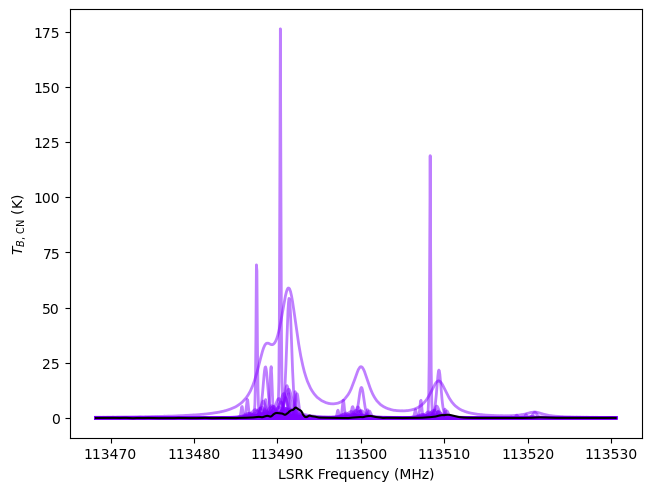

In [4]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = opt.models[1].sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(opt.models[1].data, prior.prior_predictive)

Approximate all models with variational inference.

In [5]:
start = time.time()
fit_kwargs = {
    "n": 15_000,
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.02,
}
opt.fit_all(**fit_kwargs)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 9.837e+05
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 3900
Interrupted at 3,899 [25%]: Average Loss = 3.8065e+05


Output()

n_cloud = 1 BIC = 5.202e+04

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 12700
Interrupted at 12,699 [84%]: Average Loss = 92,067


Output()

n_cloud = 2 BIC = 2.773e+04

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 7000
Interrupted at 6,999 [46%]: Average Loss = 85,427


Output()

n_cloud = 3 BIC = 1.571e+04

Approximating n_cloud = 4 posterior...


Output()

Finished [100%]: Average Loss = 6,489.1


Output()

n_cloud = 4 BIC = 1.411e+04

Approximating n_cloud = 5 posterior...


Output()

Finished [100%]: Average Loss = 957.4


Output()

n_cloud = 5 BIC = 1.689e+03

Approximating n_cloud = 6 posterior...


Output()

Finished [100%]: Average Loss = 35.151


Output()

n_cloud = 6 BIC = -4.085e+02

Approximating n_cloud = 7 posterior...


Output()

Finished [100%]: Average Loss = 4,246.3


Output()

n_cloud = 7 BIC = 8.375e+03

Approximating n_cloud = 8 posterior...


Output()

Finished [100%]: Average Loss = -420.65


Output()

n_cloud = 8 BIC = -1.102e+03

Approximating n_cloud = 9 posterior...


Output()

Finished [100%]: Average Loss = 6.8367e+12


Output()

n_cloud = 9 BIC = 1.667e+03

Approximating n_cloud = 10 posterior...


Output()

Finished [100%]: Average Loss = 3,729.9


Output()

n_cloud = 10 BIC = 7.345e+03

Runtime: 34.07 minutes


In [6]:
null_bic = opt.models[1].null_bic()
bics_vi = np.array([null_bic] + [model.bic(chain=0) for model in opt.models.values()])
print(bics_vi)

[ 9.83688523e+05  5.20230922e+04  2.77257808e+04  1.57118485e+04
  1.41057365e+04  1.68888268e+03 -4.08542268e+02  8.37470025e+03
 -1.10180012e+03  1.66700621e+03  7.34494121e+03]


Let's compare the BICs to MCMC.

In [ ]:
start = time.time()
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.02,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "n_init": 15_000,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(fit_kwargs=fit_kwargs, sample_kwargs=sample_kwargs, approx=False)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

In [ ]:
null_bic = opt.models[1].null_bic()
bics_mcmc = np.array([null_bic] + [model.bic(solution=0) for model in opt.models.values()])

fig, ax = plt.subplots()
ax.plot(n_clouds[1:], bics_vi[1:], 'ko', label="VI")
ax.plot(n_clouds[1:], bics_mcmc[1:], 'ro', label="MCMC")
ax.set_xlabel("n_clouds")
_ = ax.set_ylabel("VI BIC")